In [16]:
# importing libraries
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import itertools

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

SEED = 0

In [17]:
titles = pd.read_csv('title.basics.tsv.gz.tsv', sep='\t', low_memory=False)
crews = pd.read_csv('title.crew.tsv.gz.tsv', sep='\t')
principals = pd.read_csv('title.principals.tsv.gz.tsv', sep='\t')
names = pd.read_csv('name.basics.tsv.gz.tsv', sep='\t')
ratings = pd.read_csv('title.ratings.tsv.gz.tsv', sep='\t')

# saving ratings as csv
ratings.to_csv('ratings.csv', index=False)

ratings = pd.read_csv('ratings.csv')

In [18]:
# drop originalTitle and endYear column in titles 
titles.drop(['originalTitle', 'endYear','isAdult'], axis=1, inplace=True)

# drop rows with null values
titles.dropna(inplace=True)

# drop rows with \N
titles.drop(titles[titles.startYear=='\\N'].index, inplace=True) 
titles.drop(titles[titles.runtimeMinutes=='\\N'].index, inplace=True) 
titles.drop(titles[titles.genres=='\\N'].index, inplace=True) 

# drop rows with startYear<2000
titles["startYear"] = titles["startYear"].astype(int)
titles.drop(titles[titles.startYear<2000].index, inplace=True)

# drop rows with runtime<60 and runtime>360
titles["runtimeMinutes"] = titles["runtimeMinutes"].astype(int)
titles.drop(titles[titles.runtimeMinutes<60].index, inplace=True)
titles.drop(titles[titles.runtimeMinutes>360].index, inplace=True)

In [19]:
# saving as csv 
titles.to_csv('titles_clean.csv', index=False) 

# loading cleaned file
titles = pd.read_csv('titles_clean.csv')

titles.head() 


,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres
0,tt0011216,movie,Spanish Fiesta,2019,67,Drama
1,tt0016906,movie,Frivolinas,2014,80,"Comedy,Musical"
2,tt0019996,movie,Hongxia,2011,94,Action
3,tt0035423,movie,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance"
4,tt0036177,movie,Muhomatsu no issho,2008,100,"Action,Adventure"


In [20]:
# merge titles with ratings 
title_ratings = titles.merge(ratings, how='left', left_on='tconst', right_on='tconst')

# convert numVotes to int and drop rows with <100 votes
title_ratings.dropna(inplace=True)
title_ratings["numVotes"] = title_ratings["numVotes"].astype(int)
title_ratings.drop(title_ratings[title_ratings.numVotes<100].index, inplace=True)

In [21]:
# saving as csv
title_ratings.to_csv('title_ratings.csv', index=False)

# loading cleaned file
title_ratings = pd.read_csv('title_ratings.csv')
title_ratings.head() 

,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0035423,movie,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",6.4,80114
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,2020,70,Drama,6.3,140
2,tt0069049,movie,The Other Side of the Wind,2018,122,Drama,6.8,6604
3,tt0088751,movie,The Naked Monster,2005,100,"Comedy,Horror,Sci-Fi",5.3,287
4,tt0093119,movie,Grizzly II: Revenge,2020,74,"Horror,Music,Thriller",3.4,635


In [22]:
# merge principals with ratings
principals.drop(['ordering', 'job', 'characters'], axis=1, inplace=True)
principals_ratings = principals.merge(ratings, how='left', left_on='tconst', right_on='tconst')

# calculate average rating and average numVotes per person 
principals_avg_ratings = principals_ratings.groupby(['nconst']).mean()

In [23]:
# drop column
names.drop(['knownForTitles'], axis=1, inplace=True)

# merging names with principals
names_ratings = names.merge(principals_avg_ratings, how='left', left_on='nconst', right_on='nconst')

# drop null values
names_ratings = names_ratings.drop(names_ratings[names_ratings.averageRating.isnull() == True].index)

In [24]:
# saving as csv
names_ratings.to_csv('names_ratings.csv', index=False)

# loading cleaned file
names_ratings = pd.read_csv('names_ratings.csv')

names_ratings.head() 

,nconst,primaryName,birthYear,deathYear,primaryProfession,averageRating,numVotes
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous",7.098052,1372.045455
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack",7.274091,2460.359091
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department",6.124096,907.036145
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer",7.054255,3869.734043
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor",7.078378,5224.364865


In [25]:
# listing unique genres
unique_genres = []
for show_genres in title_ratings.genres.str.split(pat=','): 
    for genre in show_genres: 
        if genre not in unique_genres: 
            unique_genres.append(genre) 
print(unique_genres) 
print(len(unique_genres))

['Comedy', 'Fantasy', 'Romance', 'Drama', 'Horror', 'Sci-Fi', 'Music', 'Thriller', 'Musical', 'Action', 'Adventure', 'Documentary', 'Crime', 'Mystery', 'Animation', 'Family', 'History', 'War', 'Biography', 'Sport', 'Western', 'Adult', 'Game-Show', 'Reality-TV', 'Talk-Show', 'News', 'Short']
27


In [26]:
# each show can have >1 genre 
# -> creating a list of 0s and 1s to represent genres for that title
df = title_ratings[['tconst', 'genres']]

lst = []
for i in range(len(df)): 
    sub_lst = []
    sub_lst.append(df.tconst.iloc[i]) 
    for g in unique_genres: 
        if g in df.genres.iloc[i]: 
            sub_lst.append(1)
        else: 
            sub_lst.append(0)
    lst.append(sub_lst) 

In [32]:
genre = pd.DataFrame(lst,
                    columns=['tconst', 
                             'Comedy', 'Fantasy', 'Romance', 'Short', 
                             'Western', 'Drama', 'Thriller', 'Documentary', 
                             'Musical', 'Crime', 'Family', 'Biography', 
                             'History', 'Animation', 'Sci-Fi', 'Horror', 
                             'Action', 'Music', 'Mystery', 'Adventure', 
                             'Sport', 'War', 'Adult', 'Game-Show', 
                             'News', 'Talk-Show', 'Reality-TV'])

In [33]:
genre.head() 

,tconst,Comedy,Fantasy,Romance,Short,Western,Drama,Thriller,Documentary,Musical,...,Music,Mystery,Adventure,Sport,War,Adult,Game-Show,News,Talk-Show,Reality-TV
0,tt0035423,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0062336,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0069049,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0088751,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0093119,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# listing unique title type
unique_titleType = [] 
for titleType in title_ratings.titleType: 
    if titleType not in unique_titleType: 
        unique_titleType.append(titleType)
print(unique_titleType)
print(len(unique_titleType))

['movie', 'video', 'tvMovie', 'tvMiniSeries', 'tvEpisode', 'tvSeries', 'tvSpecial', 'videoGame']
8


In [35]:
# this is easier to do one hot because there is only 1 title type for each show
titleType = pd.get_dummies(title_ratings.titleType)
titleType = pd.concat([title_ratings.tconst,titleType], axis=1)

In [36]:
titleType.head() 

,tconst,movie,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvSpecial,video,videoGame
0,tt0035423,1,0,0,0,0,0,0,0
1,tt0062336,1,0,0,0,0,0,0,0
2,tt0069049,1,0,0,0,0,0,0,0
3,tt0088751,1,0,0,0,0,0,0,0
4,tt0093119,1,0,0,0,0,0,0,0


Analysing genres and ratings
For the analysis, I will be running train, test and evaluation on all 4 models. As this is a regression problem, I will be using Mean Absolute Error(MAE) to evaluate the model's efficiency and select the model with the least MAE.

In [37]:
# merging one hot encoded genre with ratings
genre_ratings = genre.merge(ratings, how='left') 
genre_ratings.head() 

,tconst,Comedy,Fantasy,Romance,Short,Western,Drama,Thriller,Documentary,Musical,...,Adventure,Sport,War,Adult,Game-Show,News,Talk-Show,Reality-TV,averageRating,numVotes
0,tt0035423,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6.4,80114
1,tt0062336,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6.3,140
2,tt0069049,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6.8,6604
3,tt0088751,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,5.3,287
4,tt0093119,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,3.4,635


In [38]:
# top 10 genres
total_by_genre = genre.drop('tconst', axis=1).sum().sort_values(ascending=False) 
total_by_genre.head(10) 

Short          39637
Comedy         22423
History        10664
Crime          10347
Documentary    10251
Romance        10174
Biography       9073
Western         8159
Animation       6480
Family          5634
dtype: int64

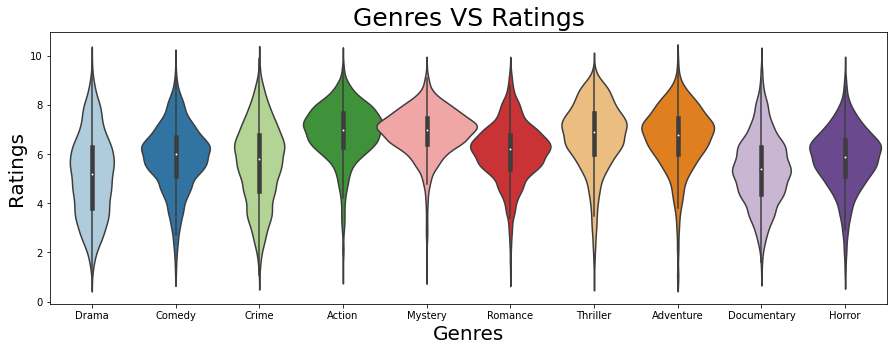

In [89]:
# visualizing top 10 in violin plot
genre_type = ['Comedy', 'Fantasy', 'Romance', 'Short', 
              'Western', 'Drama', 'Thriller', 'Documentary', 
              'Musical', 'Crime', 'Family', 'Biography', 
              'History', 'Animation', 'Sci-Fi', 'Horror', 
              'Action', 'Music', 'Mystery', 'Adventure', 
              'Sport', 'War', 'Adult', 'Game-Show', 
              'News', 'Talk-Show', 'Reality-TV']

top_10_genres = ['Drama', 'Comedy', 'Crime', 'Action',
                 'Mystery', 'Romance', 'Thriller', 'Adventure',
                 'Documentary', 'Horror']

unpivot_genre_ratings = pd.melt(genre_ratings, 
                                id_vars=['averageRating'], 
                                value_vars=top_10_genres)

unpivot_genre_ratings = unpivot_genre_ratings.loc[unpivot_genre_ratings.value>0]
unpivot_genre_ratings.rename(columns={'averageRating': 'ratings', 'variable': 'genres'}, inplace=True)

plt.figure(figsize=(15, 5))
sns.violinplot(data=unpivot_genre_ratings, 
               x='genres', 
               y='ratings', 
               gridsize=120,
               width=1.2, palette ="Paired")
plt.xlabel('Genres', size=20) 
plt.ylabel('Ratings', size=20)
plt.title('Genres VS Ratings', size=25)
plt.savefig('genres_vs_ratings.png', dpi=300)
plt.show() 

<AxesSubplot:>

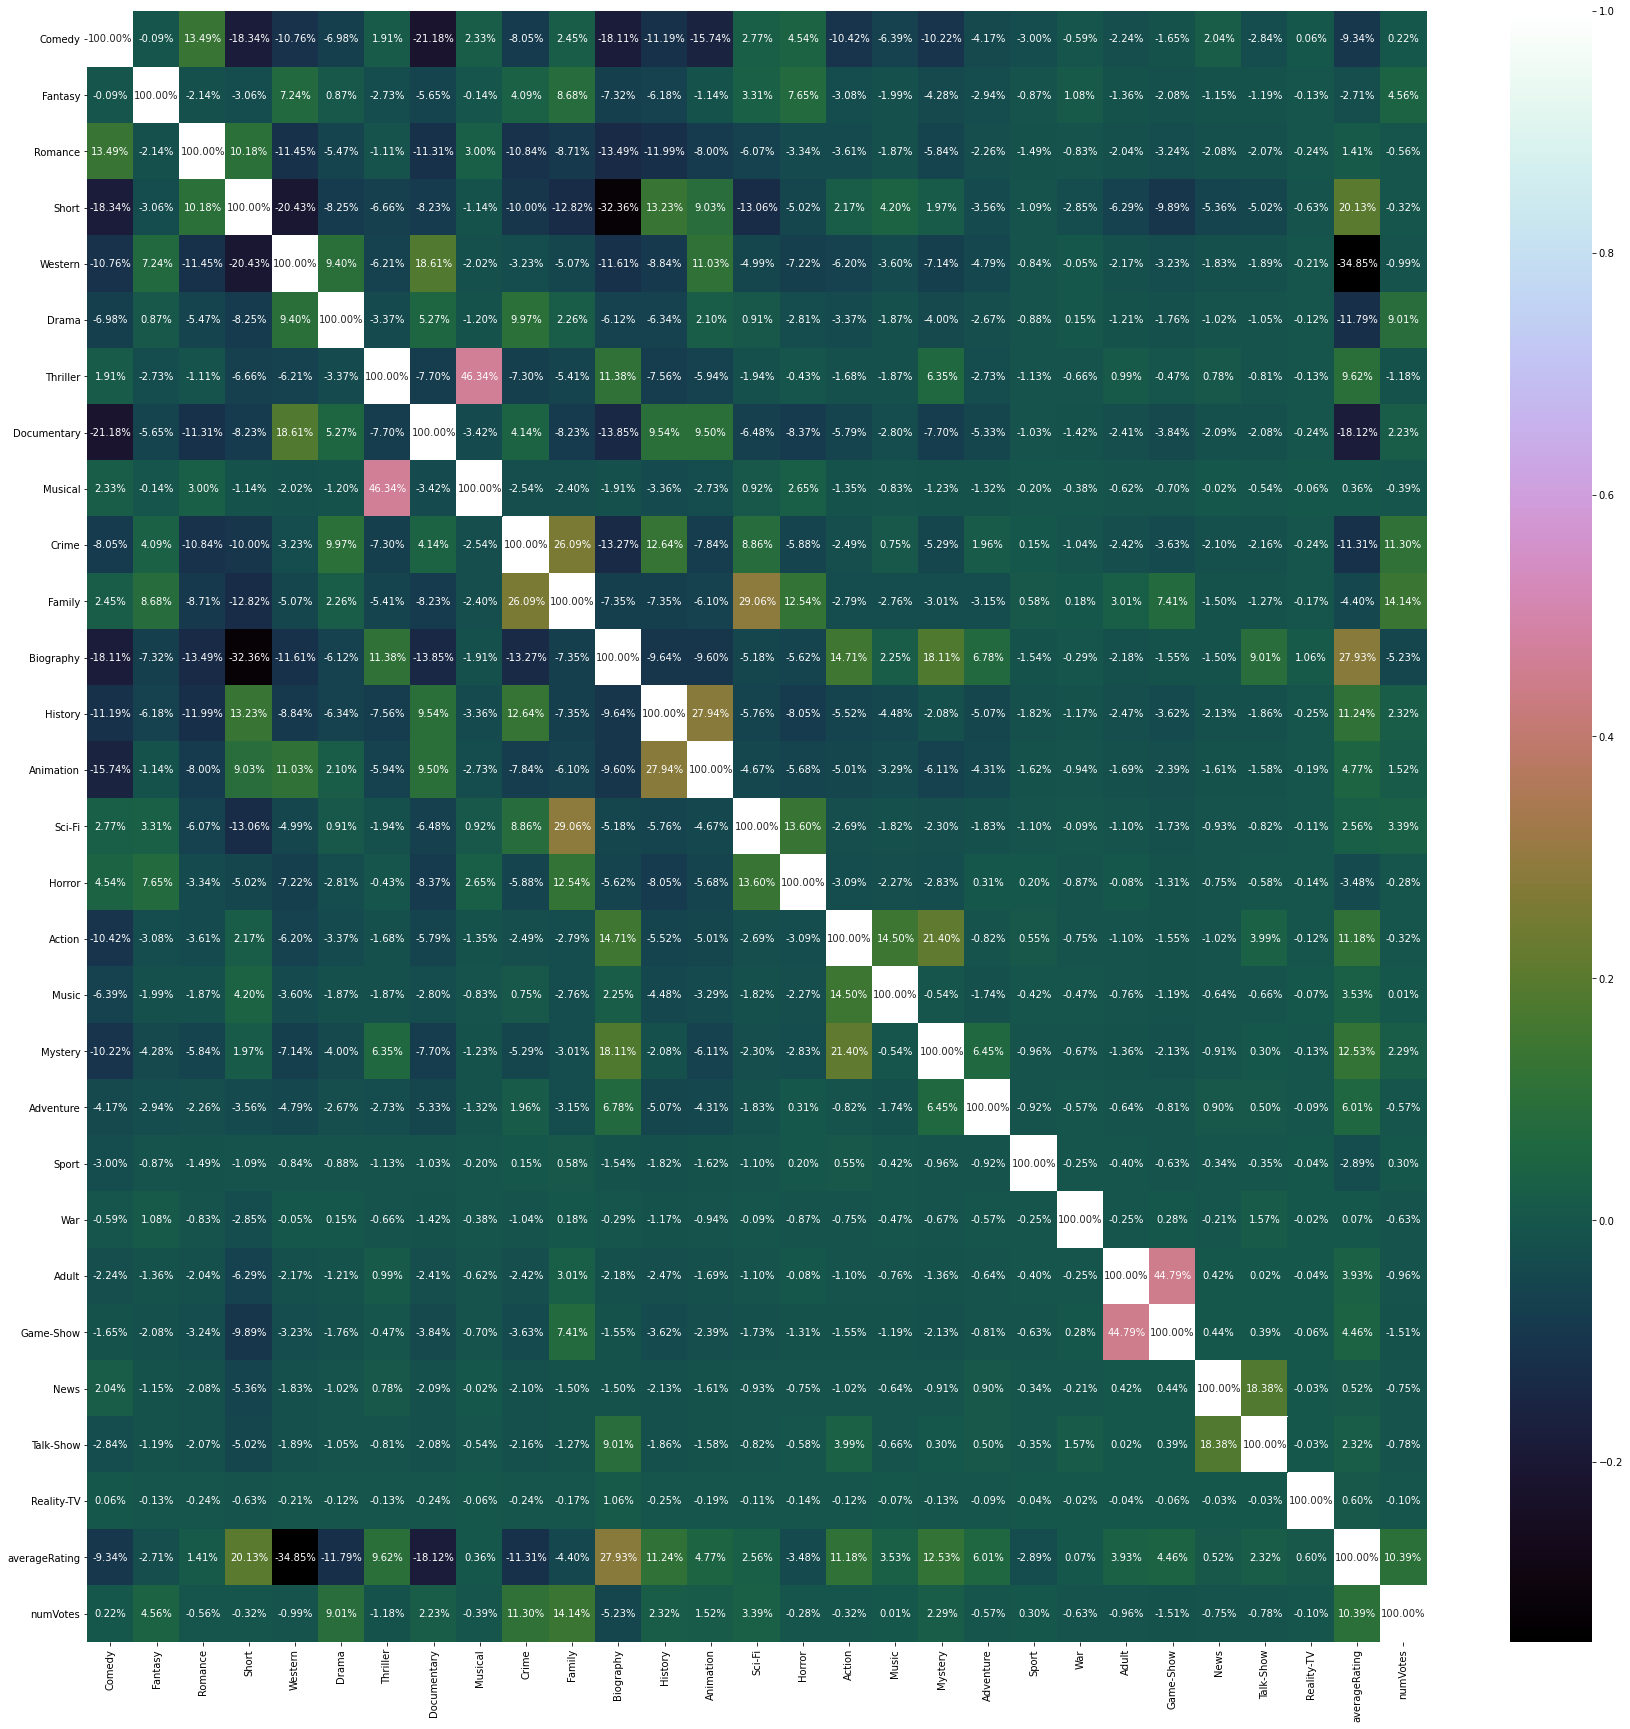

In [99]:
# correlation heatmap
fig, ax = plt.subplots(figsize=(30,30))  
sns.heatmap(genre_ratings.corr(), annot=True, annot_kws={"size":10}, fmt=".2%", cmap="cubehelix")


In [100]:
# data preparation for training and testing
X_gen = genre_ratings[['Comedy', 'Fantasy', 'Romance', 'Short', 
              'Western', 'Drama', 'Thriller', 'Documentary', 
              'Musical', 'Crime', 'Family', 'Biography', 
              'History', 'Animation', 'Sci-Fi', 'Horror', 
              'Action', 'Music', 'Mystery', 'Adventure', 
              'Sport', 'War', 'Adult', 'Game-Show', 
              'News', 'Talk-Show', 'Reality-TV']]
y_gen = genre_ratings['averageRating']

In [101]:
# splitting the data into training and testing sets
X_gen_train, X_gen_test, y_gen_train, y_gen_test = train_test_split(X_gen, y_gen,
                                                                    test_size = 0.2, 
                                                                    shuffle=True,
                                                                    random_state=SEED)

LinearRegression()

In [103]:
# train the model
LR_gen_regressor = LinearRegression() 
LR_gen_regressor.fit(X_gen_train, y_gen_train) 

LinearRegression()

In [104]:
# test the model
LR_y_gen_pred = LR_gen_regressor.predict(X_gen_test)

LR_compare_gen_df = pd.DataFrame({'Actual': y_gen_test, 
                                  'Predicted Output': LR_y_gen_pred})
LR_compare_gen_df.head()

,Actual,Predicted Output
32065,6.5,6.966420
16925,8.5,6.798254
42651,6.0,5.425860
8009,3.3,5.981028
11659,8.3,5.530903


In [105]:
# evaluate the model
LR_gen_r2 = r2_score(y_gen_test, LR_y_gen_pred)
LR_gen_MAE = mean_absolute_error(y_gen_test, LR_y_gen_pred)

print(f'Coefficients= {LR_gen_regressor.coef_}')

print(f'MAE            = {LR_gen_MAE}')
print(f'MSE            = {mean_squared_error(y_gen_test, LR_y_gen_pred)}')
print(f'RMSE           = {mean_squared_error(y_gen_test, LR_y_gen_pred, squared=False)}')
print(f'r2             = {LR_gen_r2}')


print(f'Training score = {LR_gen_regressor.score(X_gen_train, y_gen_train)}')
print(f'Test score     = {LR_gen_regressor.score(X_gen_test, y_gen_test)}')

Coefficients= [-0.02877588  0.21208244  0.09103306  0.68929967 -1.11381712 -0.29667582
  0.59748187 -0.28095842 -0.43873218 -0.23917503 -0.01007939  1.4067408
  0.42844856  0.38251634  0.72233245 -0.17659474  0.36575112  0.14694706
  0.21517657  0.45824246 -0.4562839   0.2930806   0.77697358  0.80488222
  0.52863615 -0.03107165  0.80133858]
MAE            = 0.9446906126825633
MSE            = 1.5275522596379167
RMSE           = 1.2359418512365041
r2             = 0.2841544694423216
Training score = 0.27982152691374773
Test score     = 0.2841544694423216


KNN

In [106]:
# train the model
KNN_gen_regressor = KNeighborsRegressor() 
KNN_gen_regressor.fit(X_gen_train, y_gen_train) 

KNeighborsRegressor()

In [108]:
# test the model
KNN_y_gen_pred = KNN_gen_regressor.predict(X_gen_test)

KNN_compare_gen_df = pd.DataFrame({'Actual': y_gen_test, 
                                   'Predicted Output': KNN_y_gen_pred})
KNN_compare_gen_df.head()

,Actual,Predicted Output
32065,6.5,7.04
16925,8.5,7.10
42651,6.0,5.30
8009,3.3,5.00
11659,8.3,5.48


In [109]:
# evaluate the model
KNN_gen_r2 = r2_score(y_gen_test, KNN_y_gen_pred)
KNN_gen_MAE = mean_absolute_error(y_gen_test, KNN_y_gen_pred)

print(f'MAE            = {KNN_gen_MAE}')
print(f'MSE            = {mean_squared_error(y_gen_test, KNN_y_gen_pred)}')
print(f'RMSE           = {mean_squared_error(y_gen_test, KNN_y_gen_pred, squared=False)}')
print(f'r2             = {KNN_gen_r2}')

MAE            = 0.9745931052159426
MSE            = 1.6182286556452645
RMSE           = 1.2720961660366974
r2             = 0.24166145985826715


Random Forest

In [110]:
# train the model
RF_gen_regressor = RandomForestRegressor() 
RF_gen_regressor.fit(X_gen_train, y_gen_train) 

RandomForestRegressor()

In [111]:
# test the model
RF_y_gen_pred = RF_gen_regressor.predict(X_gen_test)

RF_compare_gen_df = pd.DataFrame({'Actual': y_gen_test, 
                                  'Predicted Output': RF_y_gen_pred})
RF_compare_gen_df.head()

,Actual,Predicted Output
32065,6.5,7.093645
16925,8.5,7.316975
42651,6.0,4.912492
8009,3.3,5.532104
11659,8.3,5.533095


In [112]:
# evaluate the model
RF_gen_r2 = r2_score(y_gen_test, RF_y_gen_pred)
RF_gen_MAE = mean_absolute_error(y_gen_test, RF_y_gen_pred)

print(f'MAE            = {RF_gen_MAE}')
print(f'MSE            = {mean_squared_error(y_gen_test, RF_y_gen_pred)}')
print(f'RMSE           = {mean_squared_error(y_gen_test, RF_y_gen_pred, squared=False)}')
print(f'r2             = {RF_gen_r2}')

MAE            = 0.9147882070038407
MSE            = 1.4428155437718593
RMSE           = 1.2011725703544263
r2             = 0.3238640106014773


In [113]:
# optimal model search for genre
optimal_gen_MAE = 100 
optimal_gen_r2 = 0
optimal_gen_model = ''

# determined using lowest MAE score
if LR_gen_MAE < optimal_gen_MAE:
    optimal_gen_MAE = LR_gen_MAE
    optimal_gen_r2 = LR_gen_r2
    optimal_gen_model = 'Linear Regression' 
if KNN_gen_MAE < optimal_gen_MAE:
    optimal_gen_r2 = KNN_gen_r2
    optimal_gen_MAE = KNN_gen_MAE
    optimal_gen_model = 'K Nearest Neighbors' 
if RF_gen_MAE < optimal_gen_MAE:
    optimal_gen_MAE = RF_gen_MAE
    optimal_gen_r2 = RF_gen_r2
    optimal_gen_model = 'Random Forest' 
    

print(f'Optimal model is \033[1m{optimal_gen_model}\033[0m with MAE of \033[1m{optimal_gen_MAE}\033[0m and r2 of \033[1m{optimal_gen_r2}\033[0m')


Optimal model is Random Forest with MAE of 0.9147882070038407 and r2 of 0.3238640106014773


In [114]:
# putting it together
models = ['Linear Regression', 'K nearest neighbors','Random Forest']
genres_r2 = [LR_gen_r2, KNN_gen_r2, RF_gen_r2]
genres_MAE = [LR_gen_MAE, KNN_gen_MAE, RF_gen_MAE]
genre_metrics = pd.DataFrame(zip(models, genres_r2, genres_MAE), 
                            columns=['Genre Model', 'r2', 'MAE'])
genre_metrics.sort_values('MAE') 

,Genre Model,r2,MAE
2,Random Forest,0.323864,0.914788
0,Linear Regression,0.284154,0.944691
1,K nearest neighbors,0.241661,0.974593
